## Import

In [1]:
from __future__ import print_function
import argparse
import os, time
import random
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.autograd as autograd
import torchvision as tv
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import datasets
from torch.distributions import MultivariateNormal
from torchvision.utils import save_image

from IPython.display import HTML
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Params

In [2]:
class Options():
    def __init__(self):
        self.dataset = 'mnist'
        self.batchSize = 64
        self.imageSize = 32
        self.nz = 9999999
        self.nc = 9999999
        self.nbf = 9999999
        self.niter = 100
        self.lr = 0.0002
        self.beta1 = 0.5
        self.cuda = True
        self.ngpu = 1
        self.netG = ''
        self.netD = ''
        self.outf = 'cyz'
        self.manualSeed = 0
        self.device = "cuda:2"

opt = Options()

random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
cudnn.benchmark = True

device = torch.device(opt.device if opt.cuda else "cpu")
ngpu = int(opt.ngpu)

## Load data

dataset= mnist
dataset= mnist
dataset= mnist


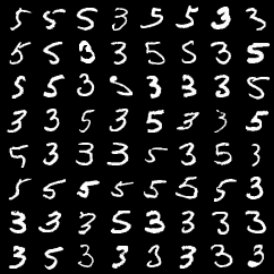

In [4]:
label_list = [3, 5]
#label_list = [0, 7]

def load_data(dataset, all_frac, val_frac, batch_size, label_list): 
    print('dataset=', dataset)
    if dataset == 'mnist':
        opt.nc, opt.nz = 1, 32
        return datasets.load_mnist(all_frac, val_frac, batch_size, img_size=opt.imageSize, label_list=label_list)
    elif dataset == 'cifar10':
        opt.nc, opt.nz = 3, 64
        return datasets.load_cifar10(all_frac, val_frac, batch_size, img_size=opt.imageSize, label_list=label_list)
    else:
        return None
    
def extract(dataloader, n):
    data_list, labels_list = [], []
    with torch.no_grad():
        for i, (data, labels) in enumerate(dataloader):
            data = data.to(device)
            labels = labels.to(device)
            data_list.append(data)
            labels_list.append(labels)
    data = torch.cat(data_list, dim=0)
    labels = torch.cat(labels_list)
    return data[0:n], labels[0:n]

train_loader, val_loader, test_loader, _ = load_data(opt.dataset, 1.0, 1.0, opt.batchSize, label_list=[label_list[0]])
imgs1, labels1 = next(iter(train_loader))

train_loader2, val_loader2, test_loader2, _ = load_data(opt.dataset, 1.0, 1.0, opt.batchSize, label_list=[label_list[1]])
imgs2, labels2 = next(iter(train_loader2))

train_loader_all, _, test_loader_all, _ = load_data(opt.dataset, 1.0, 1.0, opt.batchSize, label_list=label_list)
imgs, labels = next(iter(test_loader_all))

grid = tv.utils.make_grid(imgs[0:64], normalize=True)
tv.transforms.ToPILImage()(grid)

## Model

In [5]:
## VAE


nz = opt.nz
bf = opt.nbf
nc = opt.nc


def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

def loss_function(recon_x, x, mu, logvar):
    recon_x, x = recon_x/2+0.5, x/2+0.5
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def encode(x, netE):
    with torch.no_grad():
        mu_logvar = netE(x)
        z = mu_logvar[:, 0:nz]
        return z
        
def reconstruct(x, netE, netD):
    mu_logvar = netE(x)
    z = mu_logvar[:, 0:nz]
    x_recon = netD(z)
    return x_recon


## -------------------------------------------------------------------------------------------------------------------------------##


class Decoder(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Z latent vector 100
            nn.ConvTranspose2d(in_channels=nz, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),

            # State (1024x4x4)
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            # State (512x8x8)
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            # State (256x16x16)
            nn.ConvTranspose2d(in_channels=256, out_channels=nc, kernel_size=4, stride=2, padding=1))
        self.output = nn.Tanh()

    def forward(self, z):
        out = self.main(z.view(-1, nz, 1, 1))
        out2 = self.output(out)
        return out2
    
    
class Encoder(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main= nn.Sequential(
            # Image (Cx32x32)
            nn.Conv2d(in_channels=nc, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x16x16)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # State (512x8x8)
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.output = nn.Sequential(
            nn.Conv2d(1024, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, nz*2, 1)
        )   

    def forward(self, x):
        out =  self.main(x)
        out2 = self.output(out).view(len(x), -1)
        return out2
    

## -------------------------------------------------------------------------------------------------------------------------------## 


def train(dataloader, netE, netD):
    
    netE.train()
    netD.train()

    optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.99))
    optimizerE = optim.Adam(netE.parameters(), lr=0.0002, betas=(0.5, 0.99))

    for epoch in range(1, opt.niter):
        for batch_idx, (data, labels) in enumerate(dataloader):
            # preparation
            data = data.to(device)
            labels = labels.to(device)
            N = data.shape[0]
            optimizerD.zero_grad()
            optimizerE.zero_grad()
            
            # compute z
            mu_logvar = netE(data)            
            mu = mu_logvar[:, 0:nz]
            logvar = mu_logvar[:, nz:]
            z = reparameterize(mu, logvar)

            # compute x
            recon_batch = netD(z)
            
            # optimize!
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            optimizerD.step()
            optimizerE.step()
            
        # report
        if epoch % 5 ==0:
            print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, loss.item())) 
    print('\n')

## Train

In [6]:
TRAIN = False

netE = Encoder(ngpu).to(device)
netD = Decoder(ngpu).to(device)
netE2 = Encoder(ngpu).to(device)
netD2 = Decoder(ngpu).to(device)

if TRAIN:
    train(train_loader, netE, netD)
    train(train_loader2, netE2, netD2)
    
    torch.save(netE.state_dict(), 'models/{}_CVAE_E_{}.attack'.format(opt.dataset, nz))
    torch.save(netD.state_dict(), 'models/{}_CVAE_D_{}.attack'.format(opt.dataset, nz))
    torch.save(netE2.state_dict(), 'models/{}_CVAE_E2_{}.attack'.format(opt.dataset, nz))
    torch.save(netD2.state_dict(), 'models/{}_CVAE_D2_{}.attack'.format(opt.dataset, nz))
else:
    netE.load_state_dict(torch.load('models/{}_CVAE_E_{}.attack'.format(opt.dataset, nz)))
    netD.load_state_dict(torch.load('models/{}_CVAE_D_{}.attack'.format(opt.dataset, nz)))
    netE2.load_state_dict(torch.load('models/{}_CVAE_E2_{}.attack'.format(opt.dataset, nz)))
    netD2.load_state_dict(torch.load('models/{}_CVAE_D2_{}.attack'.format(opt.dataset, nz)))
    
netE.eval()
netD.eval()
netE2.eval()
netD2.eval()

Decoder(
  (main): Sequential(
    (0): ConvTranspose2d(32, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (output): Tanh()
)

## Test

In [7]:
def visualize(n, netD, title):
    z_list = []
    z = torch.randn(n, nz).to(device)
    with torch.no_grad():
        netD.eval()
        x = netD(z)
    save_image(x, title, nrow=int(n**0.5), normalize=True)
    
visualize(n=64, netD=netD, title='CVAE-net1.png')
visualize(n=64, netD=netD2, title='CVAE-net2.png')

## Solve z

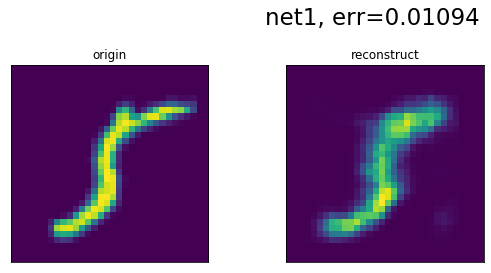

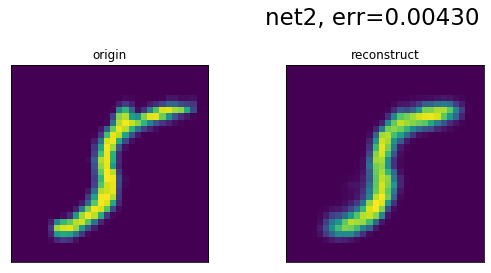

In [9]:
## Inversion: z = argmin |G(z) - x|^2_2

def solve_z(netG, x, R=5, L=200, use_amortized=False):
    n, d = len(x), opt.imageSize*opt.imageSize*opt.nc
    netG.eval()
    if use_amortized:
        z = encode(x, netE).repeat(1, 1).clone().detach().requires_grad_(True)
    else:
        z = torch.randn(R, nz, device=device).clone().detach().requires_grad_(True)
    optimizer = optim.Adam([z], lr=0.01, betas=(0.5, 0.99))
    for l in range(L):
        optimizer.zero_grad()
        mse, kld = loss_invert(netG(z), x.view(n, -1).repeat(R, 1), z, z*0)
        loss = mse + kld
        Loss = torch.mean(loss, dim=0)
        Loss.backward()
        optimizer.step()
        
    val, idx = torch.min(loss, dim=0)
    return z[idx:idx+1], loss[idx].item()

def loss_invert(recon_x, x, mu, logvar):
    recon_x, x = recon_x/2+0.5, x/2+0.5
    n, d = len(x), opt.imageSize*opt.imageSize*opt.nc
    MSE = torch.norm(recon_x.view(n, -1)-x.view(n, -1), dim=1)**2
    KLD = -0.5 * torch.sum(1 + logvar.view(n, -1) - mu.pow(2).view(n, -1) - logvar.view(n, -1).exp(), dim=1)
    return MSE/d, KLD/d

def draw_img(x, x_rec, title, subtitle='origin', subtitle2='reconstruct'):
    fig=plt.figure(figsize=(14,8))
    fig.suptitle(title,fontsize=23)

    ax=fig.add_subplot(231)
    plt.title(subtitle)
    CS=plt.imshow(tv.transforms.ToPILImage()(x.view(nc, opt.imageSize, opt.imageSize).cpu()/2+0.5))
    ax.set_xticks([])
    ax.set_yticks([])

    ax=fig.add_subplot(232)
    plt.title(subtitle2)
    CS=plt.imshow(tv.transforms.ToPILImage()(x_rec.view(nc, opt.imageSize, opt.imageSize).cpu()/2+0.5))
    ax.set_xticks([])
    ax.set_yticks([])


X, Y = extract(test_loader_all, n=100)
index = (torch.rand(1)*100).int().item()
x = X[index:index+1]

z, err = solve_z(netD, x.clone().detach(), R=15, L=500, use_amortized=False)
err, kld = loss_invert(x, netD(z), z, z*0)
x_rec = netD(z)
draw_img(x=x, x_rec=x_rec, title='net1, err={:.5f}'.format(err.item()))

z2, err2 = solve_z(netD2, x.clone().detach(), R=15, L=500, use_amortized=False)
err2, kld2 = loss_invert(x, netD2(z2), z2, z2*0)
x_rec2 = netD2(z2)
draw_img(x=x, x_rec=x_rec2, title='net2, err={:.5f}'.format(err2.item()))

## Attack

step:  success_rate= 1.0 distortion= 0.010965405032038689
next beta= tensor([2.5000], device='cuda:2')

 

step:  success_rate= 0.0 distortion= 0.010965405032038689
next beta= tensor([3.7500], device='cuda:2')

 

step:  success_rate= 1.0 distortion= 0.010103128850460052
next beta= tensor([3.1250], device='cuda:2')

 

step:  success_rate= 0.0 distortion= 0.010103128850460052
next beta= tensor([3.4375], device='cuda:2')

 

step:  success_rate= 1.0 distortion= 0.010103128850460052
next beta= tensor([3.2812], device='cuda:2')

 

adv mse= tensor([0.0101])
y= tensor([1], device='cuda:2')
average l2 distortion= 0.010103128850460052 

recon err1= 0.008127981796860695 recon err2 0.0086317528039217


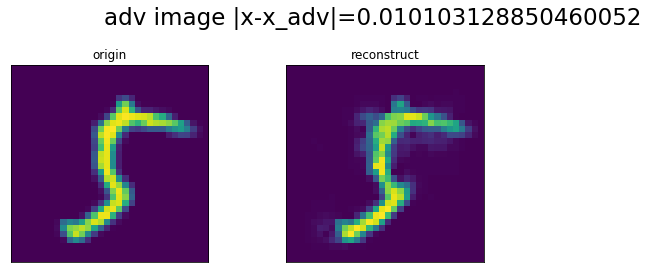

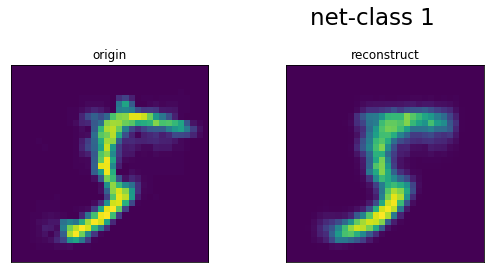

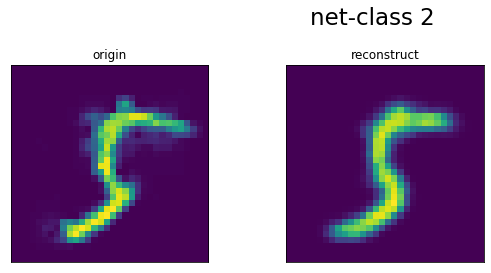

In [17]:
## Backtracking attack

ATK_BETA = 5  
ATK_OUTER_T = 50
ATK_INNER_T = 500
ATK_LR = 0.01  
ATK_BINARY_SEARCH = 5

# classification loss
def CW_loss(x_adv, y, z1, z2, netG1, netG2):
    ATK_CONFIDENCE = 0.0005
    loss1, _ = G_loss(x_adv, z1, netG1)
    loss2, _ = G_loss(x_adv, z2, netG2)
    loss_CW = (1-y)*F.relu(loss2 - loss1 + ATK_CONFIDENCE) + y*F.relu(loss1 - loss2 + ATK_CONFIDENCE)
    success_flag = (1-y)*(loss2 < loss1 - ATK_CONFIDENCE) + y*(loss1 < loss2 - ATK_CONFIDENCE)
    return loss_CW, success_flag

# generative loss
def G_loss(x, z, netG):
    x_rec = netG(z)
    mse, kld = loss_invert(x_rec, x, mu=z, logvar=z*0)
    loss_G = mse + kld
    return loss_G, loss_G
    
# reconstruction loss
def D_loss(x, x_adv):
    n, d = len(x), opt.imageSize*opt.imageSize*opt.nc
    D = torch.norm(x.view(n,-1)-x_adv.view(n,-1), dim=1)**2/d
    return D, D

# ----------------------------------------------------------------------------------------------------------- #

def z_step(x_adv, netG):
    z, err = solve_z(netG, x_adv.clone().detach(), R=15, L=ATK_INNER_T, use_amortized=False)
    return z
    
def x_step(z, x_adv, netG, lr=ATK_LR):   
    # def function
    def grad_z2x(x, z, netG):
        grad = []
        for i in range(len(x)):
            x_i, z_i = x[i].view(1, nc, opt.imageSize, opt.imageSize), z[i].view(1, nz)
            f, _ = G_loss(x_i, z_i, netG)
            grad_f, = autograd.grad(f, z_i, create_graph=True)
            grad.append(grad_f.view(1, -1))
        return torch.cat(grad, dim=0)
        
    K = 5
    eps = 1e-10
    
    # revert step: find new z0 
    netG.zero_grad()
    z_start = z.clone().detach().requires_grad_(True)
    for _ in range(K):
        grad = grad_z2x(x_adv.clone().detach(), z_start, netG)
        LR = lr/(torch.norm(grad.data.clone().detach(), dim=1, keepdim=True)+eps)
        z_start = z_start + LR*grad
    
    # forward step: z* = f(z0, x_adv) 
    netG.zero_grad()
    z_end = z_start.clone().detach().requires_grad_(True)
    for _ in range(K):
        grad = grad_z2x(x_adv, z_end, netG)
        LR = lr/(torch.norm(grad.data.clone().detach(), dim=1, keepdim=True)+eps)
        z_end = z_end - LR*grad
        
    return z_start, z_end
    
# ----------------------------------------------------------------------------------------------------------- #
    
def determine_eta(x, y, z, netG):
    lr = [0.25,0.5,1,4,8,16]
    score = torch.zeros(len(lr), 1)
    for i in range(len(lr)):
        lr[i] = lr[i]*ATK_LR
        x = x.clone().detach().requires_grad_(True)
        z = z.clone().detach().requires_grad_(True)
        z_start, z_end = x_step(z, x, netG, lr=lr[i])
        loss, loss_start, loss_end = G_loss(x, z, netG)[0], G_loss(x, z_start, netG)[0], G_loss(x, z_end, netG)[0]
        A, B = loss_start - loss, loss_end - loss
        score[i] = (A/B).item() * ((A/loss) > 0) * ((B/loss) < 0.02)
    val, idx = torch.max(score, dim=0)
    return lr[idx]
        
def attack_batch(x, y, netG1, netG2):
 
    n = len(x)
    x = x.clone().detach()
    x_adv = x.clone().detach().requires_grad_(True)
  
    beta = torch.zeros(len(x)).to(x.device) + ATK_BETA
    lower_beta, upper_beta = torch.zeros(n).to(x.device), torch.zeros(len(x)).to(x.device)+1e9  
    best_adv_x = torch.zeros_like(x).detach().to(x.device)
    best_adv_norm = torch.zeros(n).detach().to(x.device)+1.0
    history_success_flag = 0.0*(y>0).int().view(-1)
    BINARY_T = 0

    while BINARY_T<ATK_BINARY_SEARCH:
            BINARY_T += 1
            success_flag = 0.0*(y>0).int().view(-1)

            for T in range(ATK_OUTER_T):
                x_adv = x_adv.clone().detach().requires_grad_(True)

                # z-step
                z1 = z_step(x_adv, netG1)
                z2 = z_step(x_adv, netG2)
                    
                # record the best attack so far
                if T>=1:
                    loss_D, D = D_loss(x, x_adv)
                    loss_CW, sf = CW_loss(x_adv, y, z1, z2, netG1, netG2)
                    idx = ((sf==1).int() * (D<best_adv_norm).int()).nonzero().view(-1)
                    best_adv_x[idx] = x_adv[idx].clone()
                    best_adv_norm[idx] = D[idx].clone()
                    success_flag = success_flag.view(-1).int() | sf.view(-1).int()
                    history_success_flag = history_success_flag.view(-1).int() | success_flag.view(-1).int()
                    acc = history_success_flag.sum().item()/n
                                           
                # x-step
                eta1 = determine_eta(x, y, z1, netG1)
                eta2 = determine_eta(x, y, z2, netG2)
                z1_start, z1_end = x_step(z1, x_adv, netG1, lr=eta1)
                z2_start, z2_end = x_step(z2, x_adv, netG2, lr=eta2)
                loss_D, _ = D_loss(x, x_adv)
                loss_CW, _ = CW_loss(x_adv, y, z1_end, z2_end, netG1, netG2)
                loss = torch.mean(loss_D + beta*loss_CW)
                loss.backward()   
                grad_x = torch.sign(x_adv.grad.data)
                LR = 0.04*(1-T/ATK_OUTER_T) + 0.005
                x_adv.data = x_adv.data - LR*torch.sign(grad_x)
                x_adv.data = torch.clamp(x_adv.data, min=-1.0, max=1.0)
                
                # Debug                
                if T%5==0 and False:
                        loss_G_original, _ = G_loss(x_adv, z1, netG1)
                        loss_G_start, _ = G_loss(x_adv, z1_start, netG1)
                        loss_G_end, _ = G_loss(x_adv, z1_end, netG1)
                        loss_D, _ = D_loss(x, x_adv)
                        loss_G1, _ = G_loss(x_adv, z1, netG1)
                        loss_G2, _ = G_loss(x_adv, z2, netG2)
                        print('T=', T)
                        print('z.origin.loss:', loss_G_original[0].item())
                        print('z.start.loss:', loss_G_start[0].item())
                        print('z.end.loss:', loss_G_end[0].item())
                        print('|x-x_adv|:', loss_D[0].item())
                        print('loss G1:', loss_G1[0].item())
                        print('loss G2:', loss_G2[0].item())
                        print('lr1=', eta1)
                        print('lr2=', eta2)
                        print('success_flag=', success_flag)
                        print('best_adv_norm', best_adv_norm)
                        print('\n')
                        
            # change beta
            new_beta_when_success = (beta + lower_beta)/2
            new_beta_when_failure = torch.min(beta*5, upper_beta)/2 + beta/2
            upper_beta = torch.where(success_flag==1, beta, upper_beta)
            lower_beta = torch.where(success_flag==0, beta, lower_beta)
            beta = torch.where(success_flag==1, new_beta_when_success, new_beta_when_failure)
            
            # print results
            print('step:', ' success_rate=', success_flag.sum().item()/n, 'distortion=', torch.mean(best_adv_norm).item())
            print('next beta=', beta)
            print('\n \n')
    return best_adv_x.clone().detach(), best_adv_norm.clone().detach()

def attack(x_population, y_population, netG1, netG2):
    bs = 1
    n_bs = max(int(len(x_population)/bs), 1)
    x_chunks, y_chunks = torch.chunk(x_population, n_bs), torch.chunk(y_population, n_bs)
    x_adv_population, norm_adv_population = [], []
    for i in range(len(x_chunks)):
        t1 = time.time()
        x, y = x_chunks[i], y_chunks[i]
        x_adv, norm = attack_batch(x, y, netG1, netG2)
        x_adv_population.append(x_adv)
        norm_adv_population.append(norm)
        t2 = time.time()
        print('finish: {}/{}'.format(i, len(x_chunks)), file=open('progress_ABS_BTA.txt', 'w'))
    x_adv_population, norm_adv_population = torch.cat(x_adv_population, dim=0), torch.cat(norm_adv_population, dim=0)
    return x_adv_population, norm_adv_population
   
# ----------------------------------------------------------------------------------------------------------- #
        
# Preparation
X, Y = extract(test_loader_all, n=100)
x, y = X[0:1], Y[0:1]
n, d = len(x), opt.imageSize*opt.imageSize*opt.nc

# Attack
x_adv, distortion_adv = attack(x, y, netD, netD2)
results = {'x_adv': x_adv.cpu(), 'distortion_adv': distortion_adv.cpu()}
# SAVE = False
# if SAVE:
#     results = {'x_adv': x_adv.cpu(), 'distortion_adv': distortion_adv.cpu()}
#     torch.save(results, 'results/{}_ABS_{}.attack'.format(opt.dataset, nz))
# else:
#     results = torch.load('results/{}_ABS_{}.attack'.format(opt.dataset, nz))
#     x_adv, distortion_adv = results.get('x_adv').to(device), results.get('distortion_adv')
x_adv, distortion_adv = results.get('x_adv').to(device), results.get('distortion_adv')
avg_distortion = torch.mean(distortion_adv).item()
print('adv mse=', distortion_adv)
print('y=', y)
print('average l2 distortion=', avg_distortion, '\n')

# Display
idx = 0
draw_img(x[idx:idx+1], x_adv[idx:idx+1], 'adv image |x-x_adv|={}'.format(distortion_adv[idx]))
z1, err1 = solve_z(netD, x_adv[idx:idx+1], R=15, L=ATK_INNER_T)
draw_img(x_adv[idx:idx+1], netD(z1), 'net-class 1')
z2, err2 = solve_z(netD2, x_adv[idx:idx+1], R=15, L=ATK_INNER_T)
draw_img(x_adv[idx:idx+1], netD2(z2), 'net-class 2')
print('recon err1=', err1, 'recon err2', err2)